<a href="https://colab.research.google.com/github/tobiashomie/image-detection/blob/main/TL_using_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required packages

In [5]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Data preprocessing

## Data Download

In [6]:
# load data source from online
dataset_url ='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=dataset_url, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")
train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

# compose datasets for training and validation
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


['cats', 'dogs']


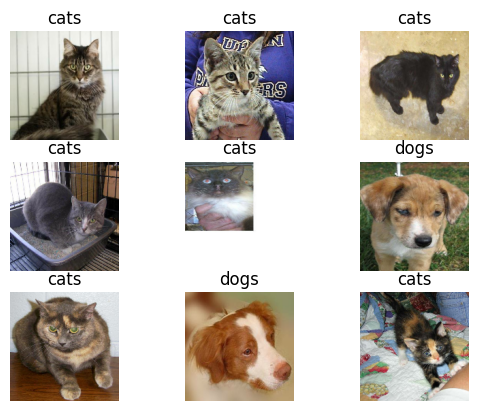

In [7]:
# show the first nine images and labels from the training set
class_names = train_dataset.class_names
print(class_names)

# take the first batch to show
for images, labels in train_dataset.take(1):
  # iterate the first 9 images
  for i in range(9):
    # extract data
    image = images[i].numpy().astype('uint8')
    label = labels[i]
    class_name = class_names[label]
    # show data
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

In [9]:
# determine how many batches of data is available for validation
val_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of batches in validation dataset: %d' % tf.data.experimental.cardinality(validation_dataset))

# compose test dataset from validation dataset (20%)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# show result
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of batches in validation dataset: 26
Number of validation batches: 21
Number of test batches: 5


In [10]:
# configure dataset to use buffer-prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

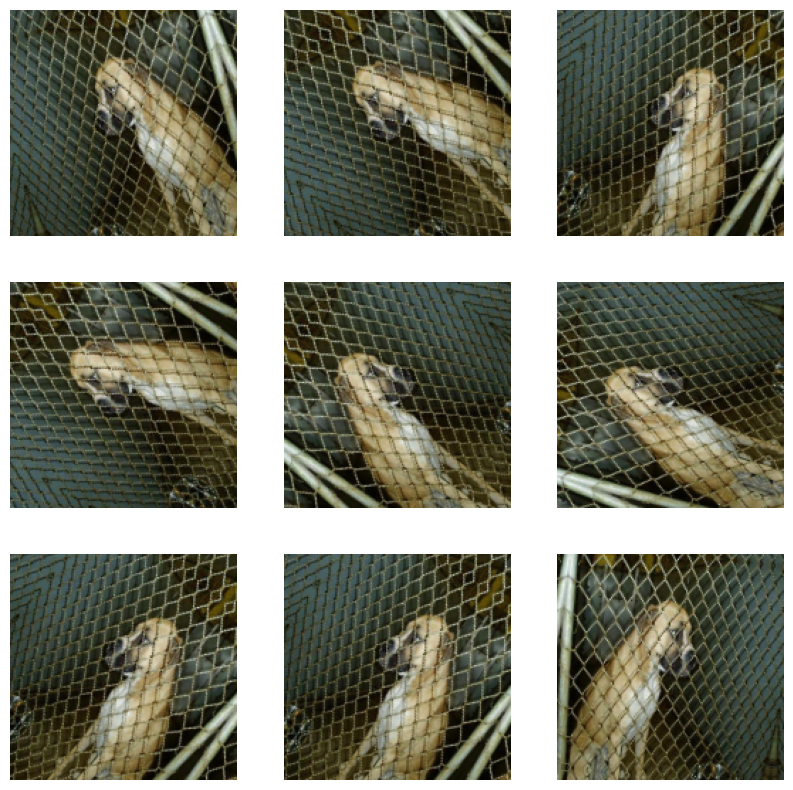

In [12]:
# compose data augomentation object
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

# show augmentation result for the first image
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# apply data-augmentation to train dataset
# def augment_image(image):
#   image_data = tf.expand_dims(image, axis=0)
#   return data_augmentation(image_data)

# train_dataset = train_dataset.map(augment_image)

In [ ]:
# rescale pixel values
rescale = tf.keras.layers.Rescaling(scale=2.0/255.0, offset=-1.0)

# Create base model from the pre-trained model (MobileNet v2)

In [20]:
# load pre-trained model without the classification layer
IMAGE_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')

# freeze the convolutional base
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

# Feature extractor

In [21]:
# feature extractor
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)
